### <p style="text-align: center;">Community Segmentation</p>
# <p style="text-align: center;">Country Profiles</p>
#### <p style="text-align: center;">Jeffrey D Nelson and David N Campbell</p>

The purpose of this notebook is to use K-Means to group countries based on socio-economic and health factors. This grouping will be used to determine which countries are in greatest need of relief.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set seaborn defaults
sns.set()

df = pd.read_csv(r'data/country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [2]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Data Preprocessing

Before we can train any models, we must preprocess the data. First, we handle non-numeric features.

In this case, there is only one non-numeric feature, `country`. This was found using `df.select_dtypes(exclude=np.number).columns`. This feature is irrelevant, so we just drop it.

In [3]:
labels = df['country']
df = df.drop(columns=['country'])

Luckily, there are no missing values in this data set, so we can skip this preprocessing step.

### Scaling

After a few iterations, we determined that our clustering was performing poorly due to magnitude mismatches in the data set. Therefore, we scale the data using StandardScaler.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

<AxesSubplot:>

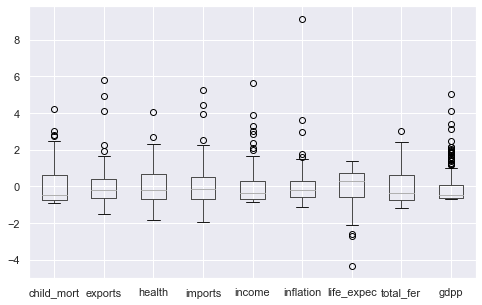

In [5]:
plt.figure(figsize=(8, 5))
df_scaled.boxplot()

### Feature Correlations

The correlation between features is an important attribute to explore. A great way to visualize these correlations is using a heat map, which seaborn makes simple.

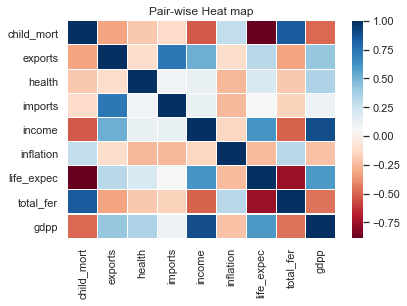

In [6]:
import seaborn as sns

g = sns.heatmap(df_scaled.corr(), annot=False, linewidths=0.1, vmax=1.0, linecolor='white', cmap=plt.cm.RdBu)
g.set_title("Pair-wise Heat map")
plt.show()

From the chart, there are many interesting correlations, but some of the strongest are listed below:
- Life expectancy is negatively correlated with child mortality. This makes sense as the death of more children will bring the overally average down.
- Exports are strongly correlated with imports. This makes sense, as countries with strong economies are likely to import and export a lot.
- Income and gdp are highly positively correlated. This makes sense because the more individuals have to spend on average, the more goods are produced to meet that demand. 
- Child mortality is negatively correlated with income. This makes sense because countries that cannot pay for child healthcare intuitively indicates that children would die more often, unfortunately.

## PCA

Since there are so many features, we use PCA to decompose to the subset that captures the majority of the variance in the dataset.

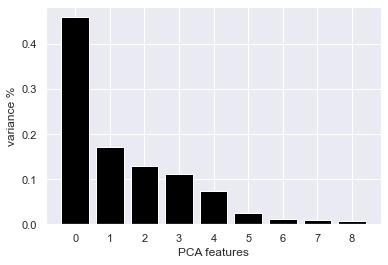

In [7]:
from sklearn.decomposition import PCA

num_features = len(df_scaled.columns)

pca = PCA(n_components=num_features)
principal_components = pca.fit_transform(df_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

It is recommended that we choose as many features as are needed to explain at least 80% of the variance. In the plot above, one can see that we will need the first 3 principle components.

In [8]:
pca = PCA(n_components=3)
df_scaled_pca = pca.fit_transform(df_scaled)

pc_df = pd.DataFrame(pca.components_.T, columns=['PC-1', 'PC-2', 'PC-3'], index=df_scaled.columns)
pc_df

,PC-1,PC-2,PC-3
child_mort,-0.419519,0.192884,-0.029544
exports,0.283897,0.613163,0.144761
health,0.150838,-0.243087,-0.596632
imports,0.161482,0.671821,-0.299927
income,0.398441,0.022536,0.301548
inflation,-0.193173,-0.008404,0.642520
life_expec,0.425839,-0.222707,0.113919
total_fer,-0.403729,0.155233,0.019549
gdpp,0.392645,-0.046022,0.122977


## K-Means

Now, let's run K-Means on these principal features.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusters = [ i for i in range(2, 15) ]

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled_pca)
    score = silhouette_score(df_scaled_pca, kmeans.predict(df_scaled_pca))
    print("Silhouette score for {num} clusters: {score}".format(num=i, score=score))

Silhouette score for 2 clusters: 0.3486469452367988
Silhouette score for 3 clusters: 0.3286444233966678
Silhouette score for 4 clusters: 0.29213683770424226
Silhouette score for 5 clusters: 0.2902046922169579
Silhouette score for 6 clusters: 0.3081536545724634
Silhouette score for 7 clusters: 0.3123785288471923
Silhouette score for 8 clusters: 0.3002388514462441
Silhouette score for 9 clusters: 0.30285920334661626
Silhouette score for 10 clusters: 0.2846506826032699
Silhouette score for 11 clusters: 0.30137851401153054
Silhouette score for 12 clusters: 0.2708131288946913
Silhouette score for 13 clusters: 0.29778301811104274
Silhouette score for 14 clusters: 0.28853283914689726


Based on silhouette score, the optimal number of clusters is 3, so we use 3 clusters to train the model. 

In [10]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_scaled_pca)

KMeans(n_clusters=3)

Now, let's visualize the centers for these clusters.

In [11]:
inverse_array = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
inverse_center_df = pd.DataFrame(scaler.inverse_transform(inverse_array), columns=df.columns)
inverse_center_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,-6.496166,115.561818,4.739171,92.232914,53494.142126,8.221950,80.890653,1.305996,40125.413098
1,73.380032,31.073436,5.839068,44.369567,2317.769574,11.593313,62.611914,4.201168,-1253.154640
2,16.219148,41.246099,7.761231,44.260434,24712.304332,4.858035,75.524156,2.165296,20989.997751


Using box plots, we can see where the cluster centers fit along the spread of the original data.

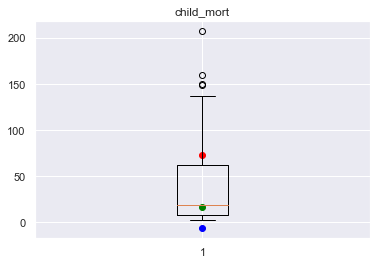

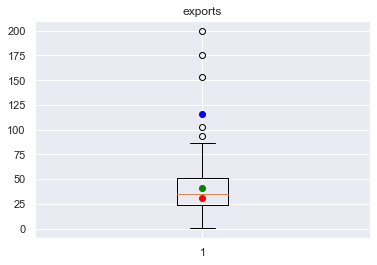

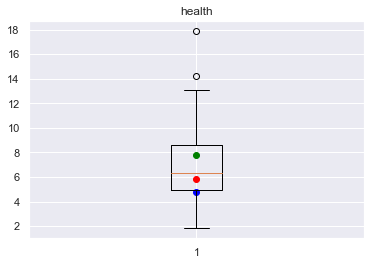

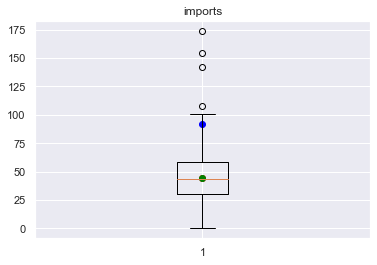

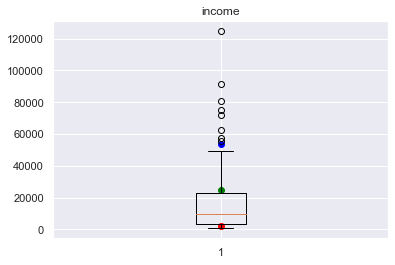

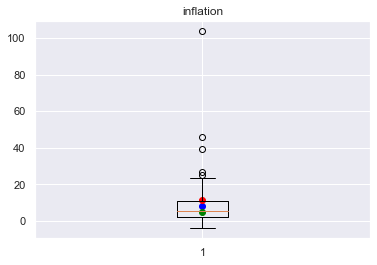

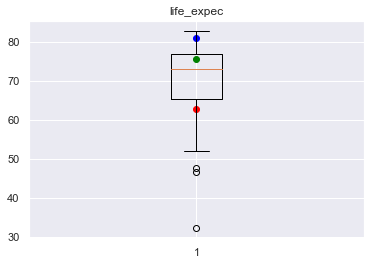

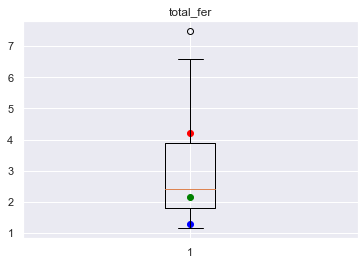

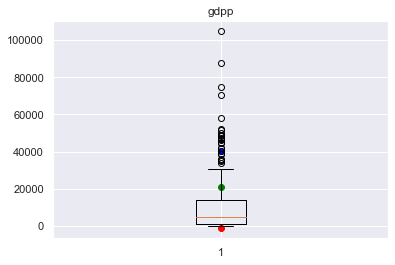

In [12]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range (len(df.columns)):
    label = df.columns[i]
    row = i // 3
    col = i % 3
    plt.figure()
    plt.title(label)
    plt.boxplot(df[label])
    for j in range(len(inverse_center_df)):
        plt.scatter(1, inverse_center_df[label][j], color=colors[j])

In [13]:
val = kmeans.predict(df_scaled_pca)
print("Cluster 0 Occurences: ", np.count_nonzero(val == 0), colors[0])
print("Cluster 1 Occurences: ", np.count_nonzero(val == 1), colors[1])
print("Cluster 2 Occurences: ", np.count_nonzero(val == 2), colors[2])

Cluster 0 Occurences:  9 blue
Cluster 1 Occurences:  68 red
Cluster 2 Occurences:  90 green


### Analysis of Clusters

The three clusters can be characterized as follows:

- *about 90 nations:* these are characterized by generally higher income and GDP. Looking at the mean centers above relative to the box plot of the whole data set, nations that have higher income and GDP have higher life expectancy and lower child mortality rate.
- *about 68 nations:* these are characterized by generally lower income and GDP. Looking at the mean centers above relative to the box plot of the whole data set, nations that have lower income, GDP, and imports/exports suffer from _severely_ higher child mortality rates and lower life expectancies. It appears that these nations do not have the economic means to increase quality of life and provide healthcare compared to the previous group.
- *about 9 nations:* these nations are the richest of the rich nations, where they have extraordinarily high GDP and imports/export with low inflation. They are the outliers that have a lot of money per capita.

Below are print outs of the countries that are members of each cluster:

In [14]:
print("Countries belonging to Cluster 0: (%s)" % colors[0])
for i in range(len(df_scaled_pca)):
    if (val[i] == 0):
        print(labels[i])

Countries belonging to Cluster 0: (blue)
Brunei
Ireland
Kuwait
Luxembourg
Malta
Qatar
Seychelles
Singapore
United Arab Emirates


In [15]:
print("Countries belonging to Cluster 1: (%s)" % colors[1])
for i in range(len(df_scaled_pca)):
    if (val[i] == 1):
        print(labels[i])

Countries belonging to Cluster 1: (red)
Afghanistan
Angola
Bangladesh
Benin
Bolivia
Botswana
Burkina Faso
Burundi
Cambodia
Cameroon
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Congo, Rep.
Cote d'Ivoire
Egypt
Equatorial Guinea
Eritrea
Fiji
Gabon
Gambia
Ghana
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
India
Indonesia
Iraq
Kenya
Kiribati
Kyrgyz Republic
Lao
Lesotho
Liberia
Madagascar
Malawi
Mali
Mauritania
Mongolia
Mozambique
Myanmar
Namibia
Nepal
Niger
Nigeria
Pakistan
Philippines
Rwanda
Samoa
Senegal
Sierra Leone
Solomon Islands
South Africa
Sudan
Tajikistan
Tanzania
Timor-Leste
Togo
Tonga
Turkmenistan
Uganda
Uzbekistan
Vanuatu
Yemen
Zambia


In [16]:
print("Countries belonging to Cluster 2: (%s)" % colors[2])
for i in range(len(df_scaled_pca)):
    if (val[i] == 2):
        print(labels[i])

Countries belonging to Cluster 2: (green)
Albania
Algeria
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Barbados
Belarus
Belgium
Belize
Bhutan
Bosnia and Herzegovina
Brazil
Bulgaria
Canada
Cape Verde
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Czech Republic
Denmark
Dominican Republic
Ecuador
El Salvador
Estonia
Finland
France
Georgia
Germany
Greece
Grenada
Hungary
Iceland
Iran
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Latvia
Lebanon
Libya
Lithuania
Macedonia, FYR
Malaysia
Maldives
Mauritius
Micronesia, Fed. Sts.
Moldova
Montenegro
Morocco
Netherlands
New Zealand
Norway
Oman
Panama
Paraguay
Peru
Poland
Portugal
Romania
Russia
Saudi Arabia
Serbia
Slovak Republic
Slovenia
South Korea
Spain
Sri Lanka
St. Vincent and the Grenadines
Suriname
Sweden
Switzerland
Thailand
Tunisia
Turkey
Ukraine
United Kingdom
United States
Uruguay
Venezuela
Vietnam


### Analysis

While 3 clusters produces the best grouping according to silhouette scores, we have to remember that our goal here is to identify those countries most in need of aid. 70 nations is likely more than one charity can handle. In order to break this down further, we have two options:
1. Run K-Means on *only* those 70 nations. This should allow us to differentiate those most in need within that larger group.
2. Choose a larger number of clusters. This should allow us to get a cluster center closest to those most in need.

For this project, we decided to go with option #2.

## Kmeans (Again)

Here we choose 10 clusters.

In [17]:
num_clusters = 10
kmeans2 = KMeans(n_clusters=num_clusters)
kmeans2.fit(df_scaled_pca)

inverse_array = pd.DataFrame(pca.inverse_transform(kmeans2.cluster_centers_), columns=df.columns)
inverse_center_df = pd.DataFrame(scaler.inverse_transform(inverse_array), columns=df.columns)
inverse_center_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,25.102448,32.636388,8.015536,40.634994,18737.508023,4.520132,73.407586,2.477892,16356.959523
1,49.980923,25.604304,5.302637,25.483846,14104.242152,16.254550,68.777883,3.467885,7987.934116
2,53.766433,51.010786,6.248163,59.799222,12811.314368,7.850854,66.782719,3.458674,8255.060405
3,-11.953212,175.346849,5.108910,154.731883,62539.556572,-2.382373,80.658548,0.899812,48048.677805
4,14.163575,69.196357,7.591811,71.405663,29702.775563,1.402598,75.462901,2.009227,24783.732715
5,4.016052,70.287148,3.844967,43.438445,45448.001074,18.617053,79.796781,1.857132,32093.303066
6,68.158017,29.969315,9.644484,66.394693,-6424.526570,-4.954275,62.041040,3.838501,-2475.430829
7,89.810044,26.213440,5.842312,46.082058,-5976.647144,11.342112,58.670398,4.764889,-8309.390846
8,-14.521026,35.102038,9.333498,35.685598,33722.459597,0.627768,82.472440,1.083155,31323.460080
9,113.135933,25.586921,-5.134121,-18.021373,14899.844319,59.165484,58.367387,6.099284,-8469.785766


In [18]:
predictions = kmeans2.predict(df_scaled_pca)

for i in range(num_clusters):
    print("Cluser %d occurrences: %d" % (i, np.count_nonzero(predictions == i)))

Cluser 0 occurrences: 36
Cluser 1 occurrences: 26
Cluser 2 occurrences: 22
Cluser 3 occurrences: 3
Cluser 4 occurrences: 17
Cluser 5 occurrences: 8
Cluser 6 occurrences: 5
Cluser 7 occurrences: 29
Cluser 8 occurrences: 20
Cluser 9 occurrences: 1


### Analysis of Clusters

From the cluster centers above, we can see that countries in cluster 7 and 9 seem to be the worst off (high child mortality, low income, low life expectancy, low gdpp). Let's print these countries.

In [19]:
predictions = kmeans2.predict(df_scaled_pca)

print("Countries belonging to Cluster 7:")
for i in range(len(df_scaled_pca)):
    if (predictions[i] == 7):
        print(labels[i])
print()

print("Countries belonging to Cluster 9:")
for i in range(len(df_scaled_pca)):
    if (predictions[i] == 9):
        print(labels[i])

Countries belonging to Cluster 7:
Afghanistan
Angola
Benin
Burkina Faso
Burundi
Cameroon
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Cote d'Ivoire
Gambia
Ghana
Guinea
Guinea-Bissau
Haiti
Kenya
Madagascar
Malawi
Mali
Mauritania
Mozambique
Niger
Senegal
Sierra Leone
Tanzania
Togo
Uganda
Zambia

Countries belonging to Cluster 9:
Nigeria


We have reduced the set of countries from 68 to 30. We could further reduce this by training on only these countries, as mentioned above, but this list should be sufficient for our non-profit to get started on delivering life-saving aid.